# Autoencoder and GMM
Nonlinear decoding using an AE before applying a GMM on the latent pace

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition
from importlib import reload

from latgmm.utils import preproc, utdata, utenso, eof, metric
from latgmm.model import ae
import latgmm.geoplot as gpl

plt.style.use("../paper.mplstyle")

## Load trained AE

In [2]:
path = "../../output/ae/ssta_eof_2_ae_hidden_16_layers_3_ep_50"
param = torch.load(path + "/config.pt")
checkpoint = torch.load(path + "/final_checkpoint.pt")

## Load data

In [3]:
reload(utdata)
datafile = "../../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
normalization = 'zscore'

ds = xr.open_dataset(datafile)

# Normalization
if normalization is not None:
    attributes = {}
    ds_norm = []
    for var in list(ds.data_vars):
        scaler = preproc.Normalizer(method=normalization)
        buff = scaler.fit_transform(ds[var])
        buff.attrs = {'normalizer': scaler}
        ds_norm.append(buff)

    ds = xr.merge(ds_norm) 

        
dataset, dataloader = utdata.data2dataset(
    ds, utdata.MultiVarSpatialData, batch_size=32,
    shuffle=True, vars=list(ds.data_vars)
)

x,l = dataset[0]
x_dim = x.shape

Open file cobe2
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file ersstv5
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file hadisst
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid on res 1
Detrend and compute anomalies:
Open file oras5
Sort longitudes and latitudes in ascending order, respectively
Process sst:
Roll longitudes.
Set the dateline to the new longitude zero.
Get selected area: lon=[-50 110], lat=[-31, 32]!
Interpolate grid 

## Create model and set weights

In [4]:
model = ae.CNNAE(x_dim, z_dim=param['z_dim'], hid_channel=param['hid_channel'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

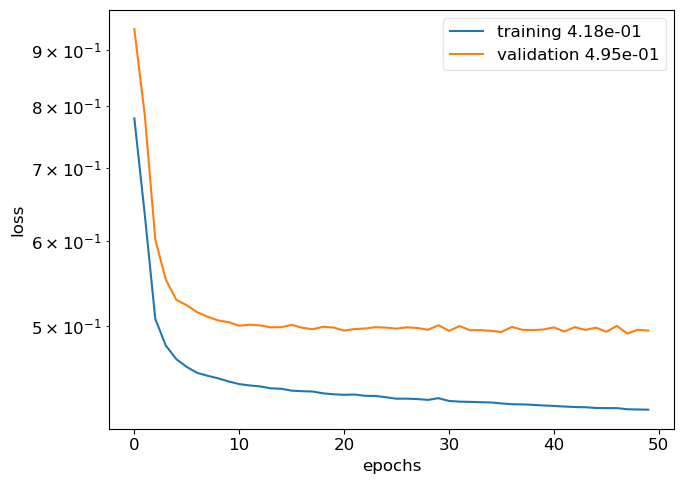

In [5]:
# Plot loss
fig, ax = plt.subplots()
ax.plot(checkpoint['train_loss'],
        label=f"training {checkpoint['train_loss'][-1]:.2e}")
ax.plot(checkpoint['val_loss'],
        label=f"validation {checkpoint['val_loss'][-1]:.2e}")
ax.set_yscale('log')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend()

### Create dataset with only DJF ENSO events

In [11]:
from latgmm.utils.dataset import SpatialData, MultiVarSpatialData
reload(utenso)
def encode_decode_data(ds: xr.Dataset, model):
    # Encode and decode enso events
    dataset, loader = utdata.data2dataset(
        ds, MultiVarSpatialData, batch_size=32,
        shuffle=False, vars=list(ds.data_vars)
    )

    for i, datapoint in enumerate(loader):
        x,l = datapoint
        x_hat, z = model.forward(x)
        if i == 0:
            x_arr = x
            x_hat_arr = x_hat
            z_arr = z
            timestamp = l['time']
        else:
            x_arr = torch.cat((x_arr, x), dim=0)
            x_hat_arr = torch.cat((x_hat_arr, x_hat), dim=0)
            z_arr = torch.cat((z_arr, z), dim=0)
            timestamp = torch.cat([timestamp, l['time']], dim=0)

    times = np.array(preproc.timestamp2time(timestamp.numpy()), dtype='datetime64[D]') + 1
    x = dataset.get_map(x_arr, dim_name='time', dim=times)
    x_hat = dataset.get_map(x_hat_arr, dim_name='time', dim=times)
    z = xr.DataArray(data=z_arr.detach().cpu().numpy(),
                     coords={'time': times, 'component': np.arange(1, z_arr.shape[-1]+1)})
    return x, x_hat, z, dataset

# Select DJF ENSO months and events
ds_enso, ds_events = utenso.select_enso_events(ds)
# Encode - decode selected events
x_enso, x_hat_enso, z_enso, dataset_enso = encode_decode_data(ds_enso, model)
x_enso_events, x_hat_enso_events, z_enso_events, _ = encode_decode_data(ds_events, model)

## Plot latent encoding

Text(0, 0.5, '$z_2$')

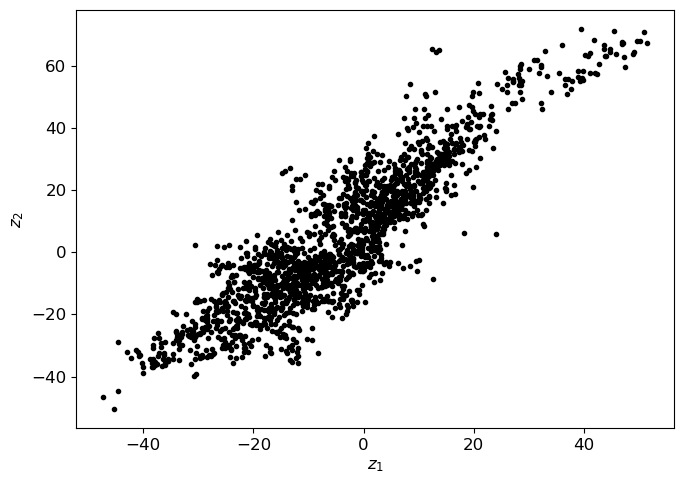

In [14]:
fig, ax = plt.subplots()
ax.plot(z_enso.isel(component=0), z_enso.isel(component=1), '.', color='k')
ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')

## Reconstruction quality

In [15]:
# Select enso events in test set
ds_test, _ = utenso.select_enso_events(ds)
x_test, x_hat_test, z_test, _ = encode_decode_data(ds_test, model)
# Flatten maps
x_flat, _ = eof.map2flatten(x_test)
x_hat_flat, _ = eof.map2flatten(x_hat_test)
metric_dict = dict(
    var= "_".join(list(x_enso.data_vars)), 
    z=model.z_dim,
    mse = ((x_hat_flat - x_flat)**2).mean(skipna=True).data,
    fuv=metric.fraction_unexplained_variance(x_flat.data, x_hat_flat.data),
)
metric_dict

{'var': 'ssta', 'z': 2, 'mse': array(0.15982735), 'fuv': 0.42095650975693}

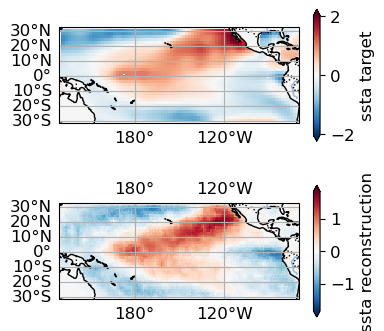

In [16]:
# Plot reconsturction
idx =110
fig = plt.figure(figsize=(4*len(x_test.data_vars), 4))
proj = ctp.crs.PlateCarree(central_longitude=180)
for j, var in enumerate(x_test.data_vars):
    ax = fig.add_subplot(2, len(x_test.data_vars), j+1, projection=proj)
    im = gpl.plot_map(x_test[var].isel(time=idx), central_longitude=180, ax=ax, 
                      bar='continuous',
                      kwargs_cb={'orientation': 'vertical', 'shrink':0.7, 'extend': 'both',
                                 "label": rf"{var} target"})
    im['gl'].top_labels = False 
    ax = fig.add_subplot(2, len(x_test.data_vars), len(x_test.data_vars)+j+1, projection=proj)
    im = gpl.plot_map(x_hat_test[var].isel(time=idx), central_longitude=180, ax=ax, 
                      bar='continuous',
                      kwargs_cb={'orientation': 'vertical', 'shrink':0.7, 'extend': 'both',
                                 "label": rf"{var} reconstruction"})

## Gaussian mixture 

### Scan number of cluster

In [17]:
n_classes = np.arange(1, 10, 1)
n_runs = 50
result = []
for k in n_classes:
    for r in range(n_runs):
        gmm = mixture.GaussianMixture(n_components=k, 
                                      covariance_type='full', max_iter=100)
        gmm.fit(z_enso.data)
        result.append(
            {'k': k, 'bic': gmm.bic(z_enso.data), 'gmm': gmm}
        )
result = pd.DataFrame(result)


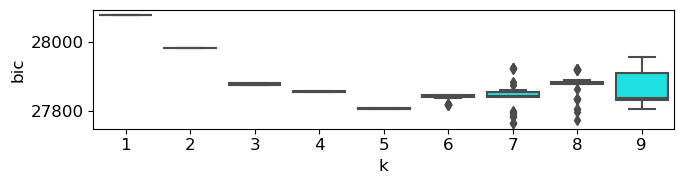

In [18]:
fig, ax = plt.subplots(figsize=(7,2))
ax = sns.boxplot(data=result, x='k', y='bic', color='cyan', ax=ax)
fig.savefig("../../output/paperplots/aegmm_bic.png", 
            transparent=True, dpi=300, bbox_inches='tight')

### Plot GMM

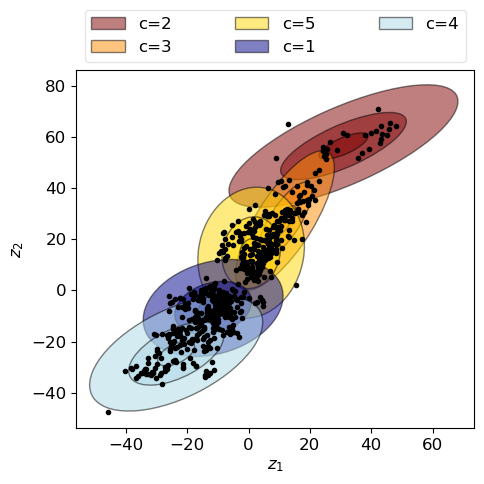

In [19]:
# Train GMM
n_cluster=5
gmm = mixture.GaussianMixture(n_components=n_cluster, 
                      covariance_type='full', max_iter=100,
                      random_state=42)
gmm.fit(z_enso.data)

# Plotting
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(z_enso_events.isel(component=0), z_enso_events.isel(component=1), '.', color='k')

# Plot gmm means
gmm_order = np.arange(gmm.means_.shape[0]) 
gmm_order = [1, 2, 4,0, 3]
gmclrs = ['maroon', 'darkorange', 'gold', 'darkblue', 'lightblue', 'black']
for i, k in enumerate(gmm_order):
    mean = gmm.means_[k, :]
    if gmm.covariance_type == "full":
        Sigma = gmm.covariances_[k, :]
    elif gmm.covariance_type == "diag":
        Sigma = np.diag(gmm.covariances_[k, :])

    gmkwargs= dict(fill=False)
    if gmclrs is not None:
        gmkwargs['ec'] = 'k' #gmclrs[i] 
        gmkwargs['fc'] = gmclrs[i] 
        gmkwargs['fill'] = True
        gmkwargs['alpha'] = 0.5

    for p in [0.9, 0.5, 0.1]:
        if p==0.1:
            gmkwargs['label'] = f"c={k+1}"
        gpl.plot_2dgaussian(mean, Sigma,
                             ax=ax, p=p, **gmkwargs)

ax.set_xlabel(r'$z_1$')
ax.set_ylabel(r'$z_2$')
ax.legend(bbox_to_anchor=(0., 1.0, 1., 0.1), loc="lower left", ncol=3, mode='expand')

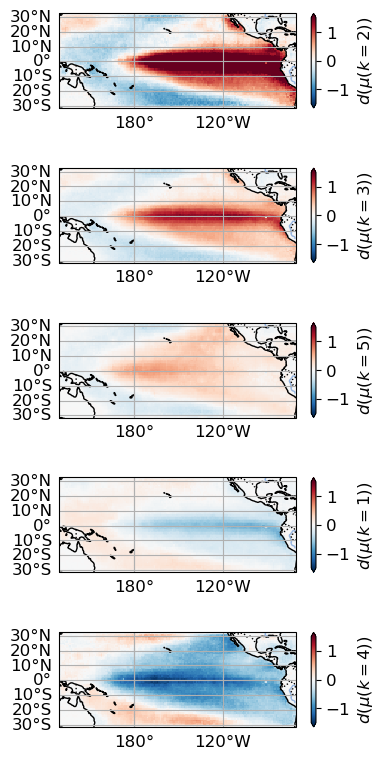

In [20]:
# Plot mean of Gaussian mixtures
vmin=-1.5
vmax=1.5

means = dataset_enso.get_map(model.decoder(torch.Tensor(gmm.means_)), dim_name='mu')

vars = means.data_vars
fig = plt.figure(figsize=(4*len(vars), 1.6*len(gmm_order)))
proj = ctp.crs.PlateCarree(central_longitude=180)
for i, k in enumerate(gmm_order):
    mu = means.sel(mu=k)
    for j, var in enumerate(vars):
        idx = len(vars)*i+j+1
        ax = fig.add_subplot(len(gmm_order), len(vars), idx, projection=proj)
        im = gpl.plot_map(mu[var], central_longitude=180, ax=ax, 
                     bar='continuous', vmin=vmin, vmax=vmax, 
                      kwargs_cb={'orientation': 'vertical', 'shrink':0.7, 'extend': 'both',
                                 "label": rf"$d(\mu (k={k+1}))$"})
        im['gl'].top_labels = False 

In [ ]:
# Save means
if False:
    means.attrs['gmm_sort'] = gmm_order
    means.to_netcdf("../../output/reanalysis/pcgmm/aegmm_means_sst_lat_30.nc")

## Probabilistic weights

In [21]:
p_c_given_x = utenso.posterior_weights(
    z_enso_events.data, means=gmm.means_, covariances=gmm.covariances_,
    prior_weights=gmm.weights_
)
# convert to xarray
p_c_given_x_da = xr.DataArray(data=p_c_given_x, dims=['time', 'classes'], 
                              coords={ 
                                'time': z_enso_events['time'].data,
                                'classes': np.arange(p_c_given_x.shape[1]) + 1
                              })

# Mean posterior weights
timepoints = np.unique(p_c_given_x_da['time'].data)
p_c_given_x_mean = []
p_c_given_x_std = []
for t in timepoints:
    weight = p_c_given_x_da.sel(time=t)
    if len(weight.shape) > 1:
        p_c_given_x_mean.append(weight.mean(dim='time').data)
        p_c_given_x_std.append(weight.std(dim='time').data)
    else:
        p_c_given_x_mean.append(weight.data)
        p_c_given_x_std.append(np.zeros(shape=5))

p_c_given_x_mean = xr.DataArray(data=p_c_given_x_mean, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        
p_c_given_x_std = xr.DataArray(data=p_c_given_x_std, coords={'time':timepoints, 'classes':p_c_given_x_da['classes']})        

array([<AxesSubplot: ylabel='p(c=2|t)'>, <AxesSubplot: ylabel='p(c=3|t)'>,
       <AxesSubplot: ylabel='p(c=5|t)'>, <AxesSubplot: ylabel='p(c=1|t)'>,
       <AxesSubplot: ylabel='p(c=4|t)'>], dtype=object)

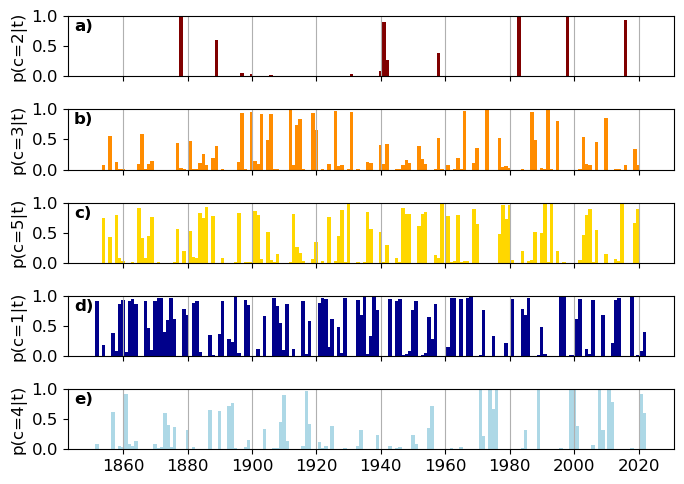

In [22]:
#  Plot posterior weights
n_samples, n_classes = p_c_given_x.shape
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_mean['time'].data, height=p_c_given_x_mean.sel(classes=k+1),
                 width=4e2, color=gmclrs[i])
    axs[i].grid(axis='x')
    axs[i].set_ylabel(f'p(c={k+1}|t)')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.75, fontsize=12)

In [24]:
# Save probability weights
if False:
    p_c_given_x_mean.attrs['gmm_sort'] = gmm_order
    p_c_given_x_mean.to_netcdf("../../output/reanalysis/pcgmm/aegmm_weights_mean_sst_lat_30.nc")

In [ ]:
# Std of weights between datasets
fig, axs = plt.subplots(n_classes, 1, figsize=(7, 1*n_classes), sharex='col', sharey='row')

for i, k in enumerate(gmm_order):
    axs[i].bar(p_c_given_x_std['time'].data, height=p_c_given_x_std.sel(classes=k+1),
                 width=4e2, color=gmclrs[i], label=rf"$\sigma$(p(c={k+1}|t))")
    axs[i].grid(axis='x')
    axs[i].set_ylabel(r'$\sigma$')
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0, .5, 1])
    axs[i].legend()

gpl.enumerate_subplots(axs, pos_x=0.01, pos_y=.75, fontsize=12)